In [17]:
import config
from src import load_data

import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, GRU

from tensorflow.keras.metrics import MeanAbsoluteError as mae
from tensorflow.keras.metrics import MeanAbsolutePercentageError as mape

In [18]:
data = load_data(config.PROCESSED_DATA_FILE)

Données chargées avec succès.


In [19]:
features = data.drop(columns=['date', 'Appliances']).values
target = data['Appliances'].values

In [20]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

features_scaled = scaler_x.fit_transform(features)
target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))

In [21]:
# Fonction de création de fenêtres temporelles
def create_windows(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i:i+window_size])
        y.append(target[i+window_size])
    return np.array(X), np.array(y)

In [22]:
# print(len(X))

In [23]:
data[data['date'] == "2016-04-27 18:00:00"]

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,wednesday,thursday,friday,saturday,sunday,sin_hour,cos_hour,is_holiday,is_school_holiday,season
15414,2016-04-27 18:00:00,360,0,21.133333,34.966667,19.5,35.326667,21.23,34.0,20.29,...,1,0,0,0,0,-1.0,-1.836970e-16,0,0,0


In [24]:
train_size = 15415
print(train_size)

15415


In [25]:
test_size = len(data) - train_size
print(test_size)

4320


In [26]:
print(train_size + test_size)

19735


In [27]:
# Fenêtrage des données
window_size = 144  # Nombre de pas de temps
X, y = create_windows(features_scaled, target_scaled, window_size)

# Division en ensembles d'entraînement, validation et test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [28]:
X_train.shape

(15415, 144, 39)

In [29]:
# RMSE (Root Mean Squared Error)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred), axis=-1))

# MAPE (Mean Absolute Percentage Error)
# def mape(y_true, y_pred):
#     return K.mean(K.abs((y_true - y_pred) / K.clip(y_true, K.epsilon(), None)), axis=-1)

In [30]:
# Modèle RNN
rnn_model = Sequential([
    Input(shape=(window_size, X_train.shape[2])),
    SimpleRNN(50, activation='tanh'),
    Dense(1)
])

rnn_model.compile(optimizer='adam', loss='mse', metrics=[mae, mape, rmse])

In [31]:
# Modèle LSTM
lstm_model = Sequential([
    Input(shape=(window_size, X_train.shape[2])),
    LSTM(50, activation='tanh'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=[mae, mape, rmse])

In [32]:
# Modèle GRU
gru_model = Sequential([
    Input(shape=(window_size, X_train.shape[2])),
    GRU(50, activation='tanh'),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse', metrics=[mae, mape, rmse])

In [46]:
import time
import matplotlib.pyplot as plt
import tensorflow as tf

class TimeHistory(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - self.epoch_start_time
        if not hasattr(self, 'epoch_times'):
            self.epoch_times = []
        self.epoch_times.append(epoch_duration)
        print(f"Temps pour l'époque {epoch+1}: {epoch_duration:.2f} secondes")


In [47]:
# Entraîner chaque modèle
batch_size = 32
epochs = 5

time_callback_rnn = TimeHistory()
time_callback_lstm = TimeHistory()
time_callback_gru = TimeHistory()

history_rnn = rnn_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[time_callback_rnn])
history_lstm = lstm_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[time_callback_lstm])
history_gru = gru_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[time_callback_gru])


Epoch 1/5
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0079 - mean_absolute_error: 0.0547 - mean_absolute_percentage_error: 51978.3906 - rmse: 0.0547Temps pour l'époque 1: 11.31 secondes
482/482 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0079 - mean_absolute_error: 0.0547 - mean_absolute_percentage_error: 51942.5508 - rmse: 0.0547
Epoch 2/5
482/482 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0079 - mean_absolute_error: 0.0526 - mean_absolute_percentage_error: 30362.6035 - rmse: 0.0526Temps pour l'époque 2: 12.89 secondes
482/482 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.0079 - mean_absolute_error: 0.0526 - mean_absolute_percentage_error: 30374.4844 - rmse: 0.0526
Epoch 3/5
480/482 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0529 - mean_absolute_percentage_error: 12086.4365 - rmse: 0.0529Temps pour l'époque 3: 12.27 secondes
482/482 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0079 - mean_absolute_error: 0.0529 - mean_absolute_percentage_error: 

In [48]:
epoch_times_rnn = time_callback_rnn.epoch_times
epoch_times_lstm = time_callback_lstm.epoch_times
epoch_times_gru = time_callback_gru.epoch_times

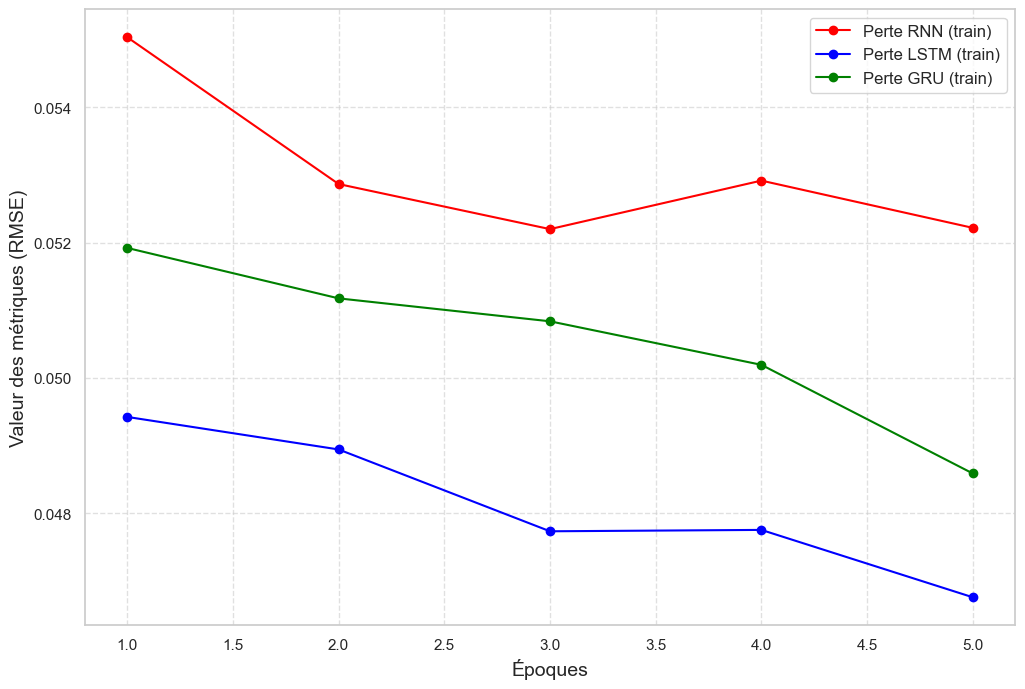

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

# Récupération des données depuis les objets history
loss_rnn = history_rnn.history['rmse']  # Perte (rmse) du modèle RNN
val_loss_rnn = history_rnn.history.get('val_rmse', None)  # Perte (rmse) de validation du modèle RNN

loss_lstm = history_lstm.history['rmse']  # Perte (rmse) du modèle LSTM
val_loss_lstm = history_lstm.history.get('val_rmse', None)  # Perte (rmse) de validation du modèle LSTM

loss_gru = history_gru.history['rmse']  # Perte (rmse) du modèle GRU
val_loss_gru = history_gru.history.get('val_rmse', None)  # Perte (rmse) de validation du modèle GRU

epochs = range(1, len(loss_rnn) + 1)  # Époques (de 1 à nb_époques)

# Création de la figure
plt.figure(figsize=(12, 8))

# Tracer la perte du modèle RNN
plt.plot(epochs, loss_rnn, label='Perte RNN (train)', color='red', marker='o')
if val_loss_rnn:
    plt.plot(epochs, val_loss_rnn, label='Perte RNN (validation)', color='orange', marker='x')

# Tracer la perte du modèle LSTM
plt.plot(epochs, loss_lstm, label='Perte LSTM (train)', color='blue', marker='o')
if val_loss_lstm:
    plt.plot(epochs, val_loss_lstm, label='Perte LSTM (validation)', color='cyan', marker='x')

# Tracer la perte du modèle GRU
plt.plot(epochs, loss_gru, label='Perte GRU (train)', color='green', marker='o')
if val_loss_gru:
    plt.plot(epochs, val_loss_gru, label='Perte GRU (validation)', color='purple', marker='x')

# Ajouter des labels, un titre, et une légende
# plt.title("Évolution des métriques en fonction des époques", fontsize=16)
plt.xlabel("Époques", fontsize=14)
plt.ylabel("Valeur des métriques (RMSE)", fontsize=14)
plt.legend(fontsize=12)

# Ajouter une grille
plt.grid(True, linestyle='--', alpha=0.6)

# Afficher le graphique

plt.show()

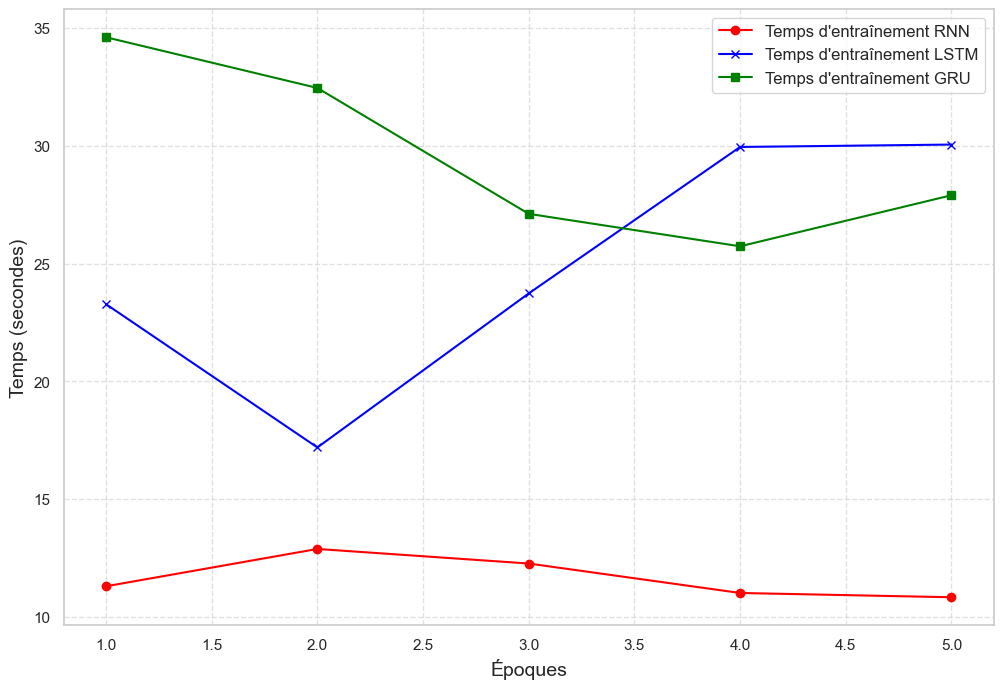

In [52]:
plt.figure(figsize=(12, 8))

# Tracer le temps d'entraînement pour chaque modèle
plt.plot(range(1, len(epoch_times_rnn) + 1), epoch_times_rnn, label='Temps d\'entraînement RNN', color='red', marker='o')
plt.plot(range(1, len(epoch_times_lstm) + 1), epoch_times_lstm, label='Temps d\'entraînement LSTM', color='blue', marker='x')
plt.plot(range(1, len(epoch_times_gru) + 1), epoch_times_gru, label='Temps d\'entraînement GRU', color='green', marker='s')

# Ajouter des labels, un titre et une légende
# plt.title("Temps d'entraînement par époque pour chaque modèle", fontsize=16)
plt.xlabel("Époques", fontsize=14)
plt.ylabel("Temps (secondes)", fontsize=14)
plt.legend(fontsize=12)

# Ajouter une grille
plt.grid(True, linestyle='--', alpha=0.6)

# Afficher le graphique
plt.show()